In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import arviz as az
import pytensor.tensor as pt
import pymc as pm
import pytensor

from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.utils.constants import ALL_STATE_AUX_DIM, ALL_STATE_DIM
from pymc_extras.statespace.models.DFM import BayesianDynamicFactor

# Introduction  

This notebook implements a **Dynamic Factor Model (DFM)** to construct a macroeconomic coincident index, capturing the common component of the *business cycle*. The implementation is inspired by the [Statsmodels example](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html) and leverages the `pymc_extras.statespace` package for building the DFM.  


# Data  

We will use a dataset of four key macroeconomic variables from the [FRED database](https://fred.stlouisfed.org/):  

- **Industrial Production** (`IPMAN`)  
- **Real Aggregate Income** (excluding transfer payments, `W875RX1`)  
- **Manufacturing and Trade Sales** (`CMRMTSPL`)  
- **Employees on Non-Farm Payrolls** (`PAYEMS`)  

In [2]:
# Download the data
# Series: INDPRO, PAYEMS, MANEMP, and RRSFS
# Monthly data from 1959-01 to 2020-12
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2014, 12, 31)

indprod = DataReader("IPMAN", "fred", start=start, end=end)
income = DataReader("W875RX1", "fred", start=start, end=end)
sales = DataReader("CMRMTSPL", "fred", start=start, end=end)
emp = DataReader("PAYEMS", "fred", start=start, end=end)

data = pd.concat((indprod, income, sales, emp), axis=1)
data.columns = ["indprod", "income", "sales", "emp"]
data.index.freq = data.index.inferred_freq

print(data.head())

            indprod  income       sales    emp
DATE                                          
1979-01-01  47.1722  5248.7  561382.192  88808
1979-02-01  47.3093  5278.5  558729.039  89055
1979-03-01  47.5389  5294.3  574897.892  89479
1979-04-01  46.7402  5242.7  559387.521  89417
1979-05-01  47.3949  5227.5  571771.305  89789


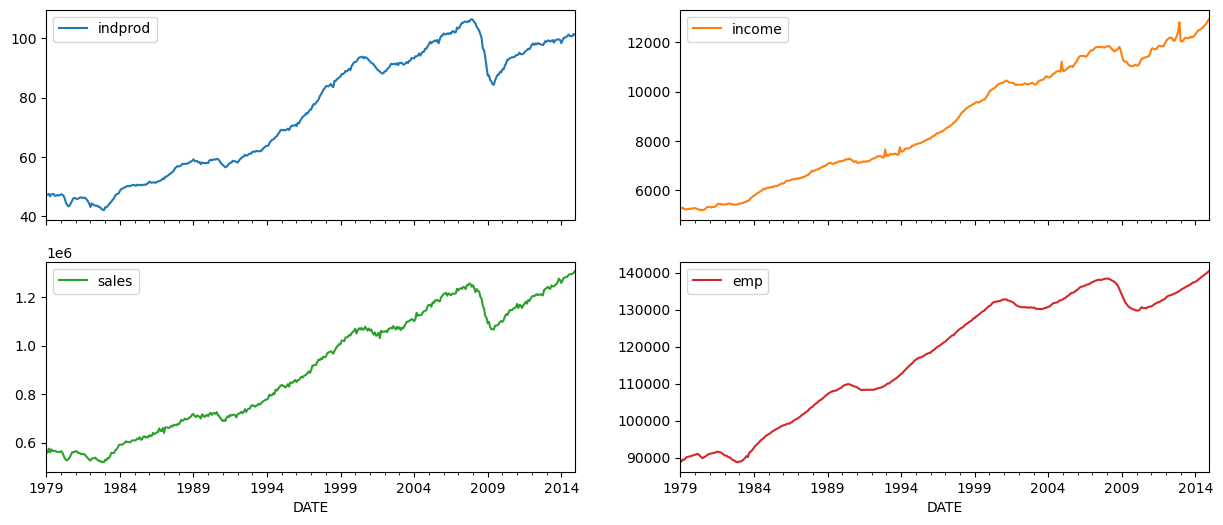

In [3]:
data.loc[:, "indprod":"emp"].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

## Stationarity Analysis and Data Transformation

### Cointegration

In [4]:
def johansen_cointegration_test(df, det_order=-1, k_ar_diff=1):
    """
    Perform Johansen cointegration test
    det_order: Deterministic trend assumption (-1 to 3)
    k_ar_diff: Lag order for differencing (usually 1)
    """
    print("Johansen Cointegration Test Results")
    coint_test = coint_johansen(df.dropna(), det_order, k_ar_diff)

    trace_stat = coint_test.lr1
    crit_values = coint_test.cvt

    for i in range(len(trace_stat)):
        print(
            f"Rank {i}: Trace Statistic = {trace_stat[i]:.2f}, 90% CV = {crit_values[i, 0]:.2f}, 95% CV = {crit_values[i, 1]:.2f}, 99% CV = {crit_values[i, 2]:.2f}"
        )
        if trace_stat[i] > crit_values[i, 1]:
            print("=> Reject H0: Cointegration rank >=", i)
        else:
            print("=> Fail to reject H0: Cointegration rank <", i)
        print()

In [5]:
coint_data = data[["indprod", "income", "sales", "emp"]]
johansen_cointegration_test(coint_data)

Johansen Cointegration Test Results
Rank 0: Trace Statistic = 85.23, 90% CV = 37.03, 95% CV = 40.17, 99% CV = 46.57
=> Reject H0: Cointegration rank >= 0

Rank 1: Trace Statistic = 27.72, 90% CV = 21.78, 95% CV = 24.28, 99% CV = 29.51
=> Reject H0: Cointegration rank >= 1

Rank 2: Trace Statistic = 6.23, 90% CV = 10.47, 95% CV = 12.32, 99% CV = 16.36
=> Fail to reject H0: Cointegration rank < 2

Rank 3: Trace Statistic = 1.36, 90% CV = 2.98, 95% CV = 4.13, 99% CV = 6.94
=> Fail to reject H0: Cointegration rank < 3



The Johansen test indicates the presence of 2 cointegrating relationships among the 4 time series. This means there are 2 independent stationary linear combinations (cointegrating vectors). However, we will follow our reference, testing stationarity for each time series and eventually applying a tranformation.


### Stationarity

In [6]:
def adf_test(series, title=""):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f"ADF Test for {title}")
    result = adfuller(series.dropna(), autolag="AIC")
    labels = ["ADF Statistic", "p-value", "# Observations"]
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")
    print()

In [7]:
for col in ["indprod", "income", "sales", "emp"]:
    adf_test(data[col], title=col)

ADF Test for indprod
ADF Statistic: -0.6730347475672281
p-value: 0.85361106826554
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for income
ADF Statistic: 0.08298432353926344
p-value: 0.9648799685690177
# Observations: 9
=> Non-stationary (fail to reject H0)

ADF Test for sales
ADF Statistic: -0.2149222275829695
p-value: 0.9367193955682982
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for emp
ADF Statistic: -0.9032661691141215
p-value: 0.7868949183862886
# Observations: 3
=> Non-stationary (fail to reject H0)



The **Augmented Dickey-Fuller (ADF) test** indicates that our time series are not stationary.  
To address this, we should apply appropriate transformations to achieve stationarity before modeling.  


In [8]:
# Create log-differenced series
data["dln_indprod"] = (np.log(data.indprod)).diff() * 100
data["dln_income"] = (np.log(data.income)).diff() * 100
data["dln_sales"] = (np.log(data.sales)).diff() * 100
data["dln_emp"] = (np.log(data.emp)).diff() * 100

# De-mean and standardize
data["std_indprod"] = (data["dln_indprod"] - data["dln_indprod"].mean()) / data["dln_indprod"].std()
data["std_income"] = (data["dln_income"] - data["dln_income"].mean()) / data["dln_income"].std()
data["std_sales"] = (data["dln_sales"] - data["dln_sales"].mean()) / data["dln_sales"].std()
data["std_emp"] = (data["dln_emp"] - data["dln_emp"].mean()) / data["dln_emp"].std()

In [9]:
# Get the endogenous data
endog = data.loc["1979-02-01":, "std_indprod":"std_emp"]

In [10]:
for col in ["std_indprod", "std_income", "std_sales", "std_emp"]:
    adf_test(endog[col], title=col)

ADF Test for std_indprod
ADF Statistic: -7.333717380953279
p-value: 1.1105668612347841e-10
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_income
ADF Statistic: -4.455094080898936
p-value: 0.00023683228344774555
# Observations: 13
=> Stationary (reject H0)

ADF Test for std_sales
ADF Statistic: -8.82793508643558
p-value: 1.8022396062718537e-14
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_emp
ADF Statistic: -4.1756318714355185
p-value: 0.0007243551568346677
# Observations: 2
=> Stationary (reject H0)



As noted in the reference notebook, following the findings of *Stock and Watson (1991)*, stationarity can be achieved by applying a **log transformation** to the series and then taking their **first differences**.  


In [11]:
print(endog.head())

            std_indprod  std_income  std_sales   std_emp
DATE                                                    
1979-02-01     0.144369    0.536870  -0.722874  0.897660
1979-03-01     0.392176    0.134841   2.867766  1.929842
1979-04-01    -2.391601   -1.787951  -3.163686 -0.918544
1979-05-01     1.550990   -0.751468   2.151995  1.616819
1979-06-01    -0.067774   -0.076092  -1.319191  1.300121


## Statsmodel


### Model specification

In this application, we consider a **dynamic factor model** with a single latent factor.  
The factor is assumed to follow an **AR(2)** process. Each observed series has its own error term, modeled as an **independent AR(2)** process. The innovations driving the factor and the errors are assumed to be mutually independent, so the covariance structure is diagonal.

Formally, the model is:

$$
y_{i,t} = \lambda_i f_t + u_{i,t}
$$

$$
u_{i,t} = c_{i,1} u_{i,t-1} + c_{i,2} u_{i,t-2} + \varepsilon_{i,t}
$$

$$
f_t = a_1 f_{t-1} + a_2 f_{t-2} + \eta_t
$$

$$
\varepsilon_{i,t} \sim \mathcal{N}(0, \sigma_i^2), \qquad 
\eta_t \sim \mathcal{N}(0, I)
$$

where \(i\) is one of: `[indprod, income, sales, emp]`.


---

This setup can be represented using the `DynamicFactor` class from **statsmodels** with the following configuration:

- `k_factors = 1` — one unobserved dynamic factor  
- `factor_order = 2` — the latent factor follows an AR(2)  
- `error_order = 2` — idiosyncratic errors are AR(2)  
- `error_var = False` — errors are treated separately rather than as a VAR (default setting)  
- `error_cov_type = 'diagonal'` — innovations are uncorrelated across series (also the default)  

---

After specifying the model, the unknown parameters are estimated by **maximum likelihood**, using the `.fit()` method.



In [12]:
# Fit the Dynamic Factor Model
mod = DynamicFactor(
    endog, k_factors=1, factor_order=2, error_order=2, error_var=False, error_cov_type="diagonal"
)
initial_res = mod.fit(method="powell", disp=False)
res = mod.fit(disp=False)
print(res.summary())

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=2)   Log Likelihood               -2050.782
                                                          + AR(2) errors   AIC                           4137.564
Date:                                                   Sun, 17 Aug 2025   BIC                           4210.754
Time:                                                           10:57:17   HQIC                          4166.462
Sample:                                                       02-01-1979                                         
                                                            - 12-01-2014                                         
Covariance Type:                                                     opg                

/opt/anaconda3/envs/pymc_extras/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We print the model matrices to allow for an easy comparison with the **PyMC Dynamic Factor Model (DFM)** implementation.  


In [13]:
# Access the state-space representation
ssm = res.model.ssm

# Print the main state-space matrices
print("\nDesign matrix (Z):")
print(ssm["design"])

print("\nTransition matrix (T):")
print(ssm["transition"])

print("\nSelection matrix (R):")
print(ssm["selection"])

print("\nState covariance matrix (Q):")
print(ssm["state_cov"])

print("\nObservation intercept (d):")
print(ssm["obs_intercept"])

print("\nState intercept (c):")
print(ssm["state_intercept"])

print("\nObservation covariance matrix (H):")
print(ssm["obs_cov"])


Design matrix (Z):
[[-0.69536284  0.          1.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.25042682  0.          0.          1.          0.          0.
   0.          0.          0.          0.        ]
 [-0.4372834   0.          0.          0.          1.          0.
   0.          0.          0.          0.        ]
 [-0.42548075  0.          0.          0.          0.          1.
   0.          0.          0.          0.        ]]

Transition matrix (T):
[[ 0.30237198  0.36710486  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.22851633  0.          0.          0.
  -0.17556443  0.          0.          0.        ]
 [ 0.          0.          0.         -0.19801159  0.          0.
   0.         -0.10249204  0.          0.        ]
 [ 0.          0.  

The **unobserved factor** is plotted below together with the **NBER recession indicators** for the U.S. economy.  
The results suggest that the factor successfully captures key features of business cycle activity.  


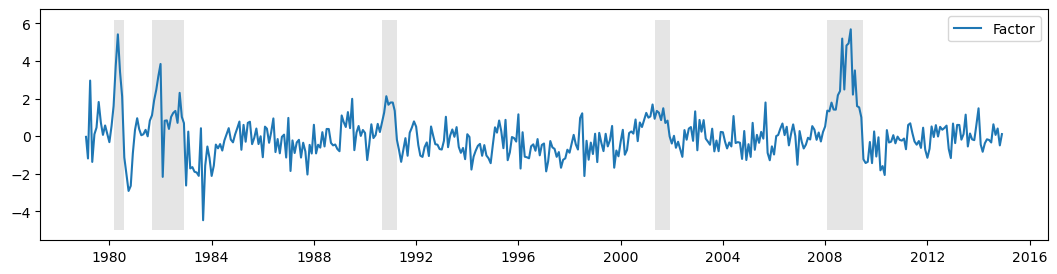

In [25]:
fig, ax = plt.subplots(figsize=(13, 3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label="Factor")
ax.legend()

# Retrieve and also plot the NBER recession indicators
rec = DataReader("USREC", "fred", start=start, end=end)
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1);

A simple way to interpret the estimated factor is to **regress it on each observed variable** and record the \(R^2\) values.  
This shows which variables the factor explains well and which it does not.  

In our model with **one factor and four variables**, the factor explains most of the variation in **industrial production**, a large portion in **employment** and **sales**, and less in **income**. 

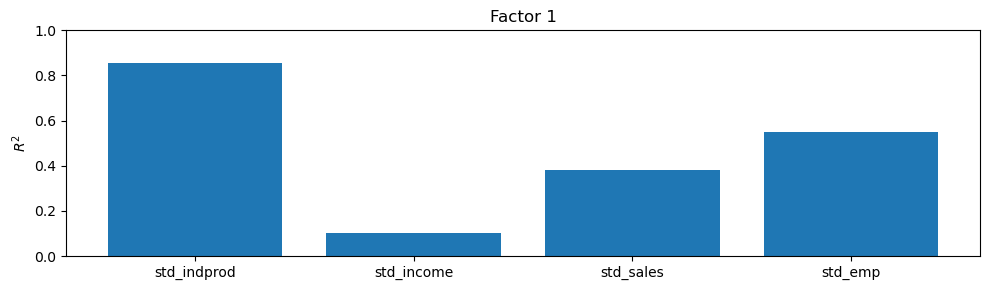

In [35]:
fig = res.plot_coefficients_of_determination(figsize=(10, 3))
ax = fig.axes[0]

var_names = res.model.endog_names

ax.set_xticks(range(len(var_names)))
ax.set_xticklabels(var_names, rotation=0, ha="center")

plt.tight_layout()
plt.show()

As already said, the goal of this model is to construct an **interpretable coincident index** that reflects the current state of the macroeconomy.  
The index is built by reconstructing the mean of the (differenced) factor and can be compared to the **US coincident index published by the Federal Reserve Bank of Philadelphia** (USPHCI on FRED).  
For details on the methodology, see *Kim and Nelson (1999)* or *Stock and Watson (1991)*.
Below we plot this reference index (USPHCI)


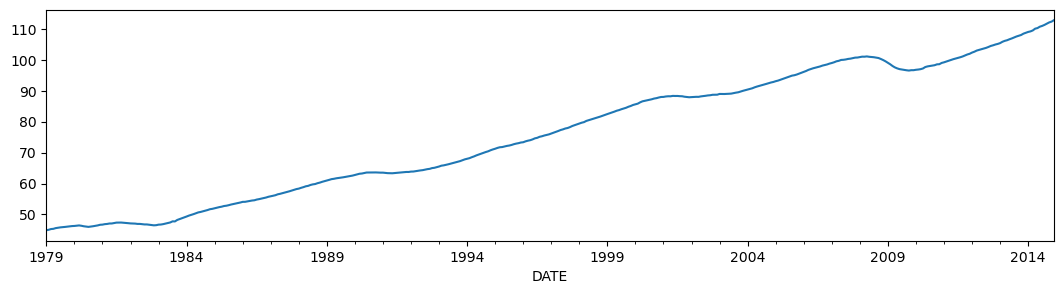

In [36]:
usphci = DataReader("USPHCI", "fred", start=start, end=end)["USPHCI"]
usphci.plot(figsize=(13, 3));

In [37]:
dusphci = usphci.diff()[1:].values


def compute_coincident_index(mod, res):
    # Estimate W(1)
    spec = res.specification
    design = mod.ssm["design"]
    transition = mod.ssm["transition"]
    ss_kalman_gain = res.filter_results.kalman_gain[:, :, -1]

    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(
        np.eye(k_states) - np.dot(np.eye(k_states) - np.dot(ss_kalman_gain, design), transition)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = np.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())

    # Normalize the factors
    factor = res.factors.filtered[0].copy()

    factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Compute the coincident index
    coincident_index = np.zeros(mod.nobs + 1)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, mod.nobs):
        coincident_index[t + 1] = coincident_index[t] + factor[t] + factor_mean

    # Attach dates
    coincident_index = pd.Series(coincident_index, index=data.index).iloc[1:]

    # Normalize to use the same base year as USPHCI
    coincident_index *= usphci.loc["1992-07-01"] / coincident_index.loc["1992-07-01"]

    return coincident_index, factor

Below we plot the calculated coincident index along with the US recessions and the comparison coincident index USPHCI.

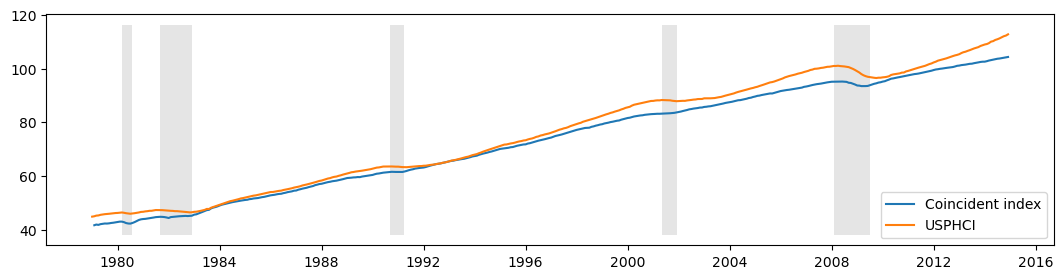

In [38]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index_res, factor_res = compute_coincident_index(mod, res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index_res, label="Coincident index")
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.legend(loc="lower right")

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1);

## PyMC

We now aim to **replicate the results obtained with Statsmodels** in a **Bayesian framework** using the `BayesianDynamicFactor` model from the `pymc-extras` package.

In [39]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

We define the **same model** in the Bayesian framework to ensure comparability with the Statsmodels results.  
The PyMC implementation uses the `BayesianDynamicFactor` class from `pymc_extras.statespace`.  
For details on its parameters, state-space formulation, and handling of exogenous variables, see the [full code](https://github.com/pymc-devs/pymc-extras/blob/main/pymc_extras/statespace/models/DFM.py#L1).  

This implementation allows greater flexibility than Statsmodels, particularly in integrating exogenous variables directly into the state-space representation.



In [21]:
# Initialize the model
dfm = BayesianDynamicFactor(
    k_endog=4,
    k_factors=1,
    factor_order=2,
    error_order=2,
    error_var=False,
    error_cov_type="diagonal",
    measurement_error=False,
    verbose=True,
)

                                     Model Requirements                                     
                                                                                            
  Variable          Shape      Constraints                                      Dimensions  
 ────────────────────────────────────────────────────────────────────────────────────────── 
  x0                (10,)                                                       ('state',)  
  P0                (10, 10)   Positive Semi-definite               ('state', 'state_aux')  
  factor_loadings   (4, 1)                                    ('observed_state', 'factor')  
  factor_ar         (1, 2)                                            ('factor', 'lag_ar')  
  error_ar          (4, 2)                              ('observed_state', 'error_lag_ar')  
  error_sigma       (4,)       Positive                                ('observed_state',)  
                                                                                            
  These parameters should be assigned priors inside a PyMC model block before calling the   
                               build_statespace_graph method.                               

Even with **simple priors**, we will show that we can obtain **robust and reliable results** for the Bayesian Dynamic Factor Model.


In [ ]:
with pm.Model() as pymc_mod:
    # Initial state
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings vector
    # We use a HalfNormal prior because in the DFM model the estimation of factor_loadings is only identified up to a sign.
    factor_loadings = pm.HalfNormal("factor_loadings", sigma=0.2, shape=(4, 1))

    # AR(2) coefficients for factor f_t
    factor_ar = pm.Normal("factor_ar", mu=0.0, sigma=0.2, shape=(1, 2))

    # AR(2) coefficients for idiosyncratic components as matrix error_ar_mu: shape (4, 2)
    error_ar = pm.Normal("error_ar", mu=0.0, sigma=0.2, shape=(4, 2))

    # Standard deviations for idiosyncratic shocks
    error_sigma = pm.HalfNormal("error_sigma", sigma=0.2, shape=(4))

    # Build symbolic graph
    dfm.build_statespace_graph(data=endog, mode="JAX")

In [23]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (10,)     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (10, 10)  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
        

In [ ]:
with pymc_mod:
    idata_dfm_py = pm.sample(
        draws=500,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        random_seed=1,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.62,7
,1500,0,0.62,7


The **Graphviz representation** visualizes the structure of the PyMC model, showing the **dependencies between variables and priors** and helping to understand the flow of information in the Bayesian Dynamic Factor Model.

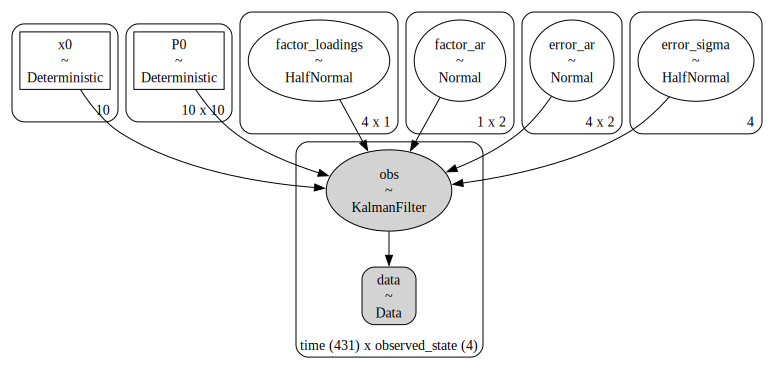

In [ ]:
pymc_mod.to_graphviz()

With the usual **energy plot**, we examine the behavior of the sampling procedure.  
It shows the **efficiency and convergence** of the MCMC chains, indicating that the sampler was able to explore the posterior distribution effectively.



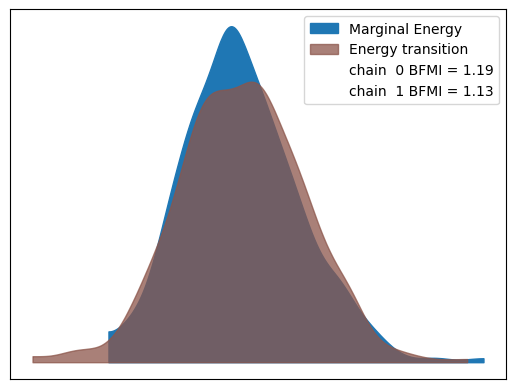

In [ ]:
az.plot_energy(idata_dfm_py);

In [ ]:
var_names_list_dfm_py = [name for name in dfm.param_names if name not in {"x0", "P0"}]

The **trace plot** visualizes the sampled values of each parameter over the MCMC iterations, showing a good sampling procedure for our state space model.

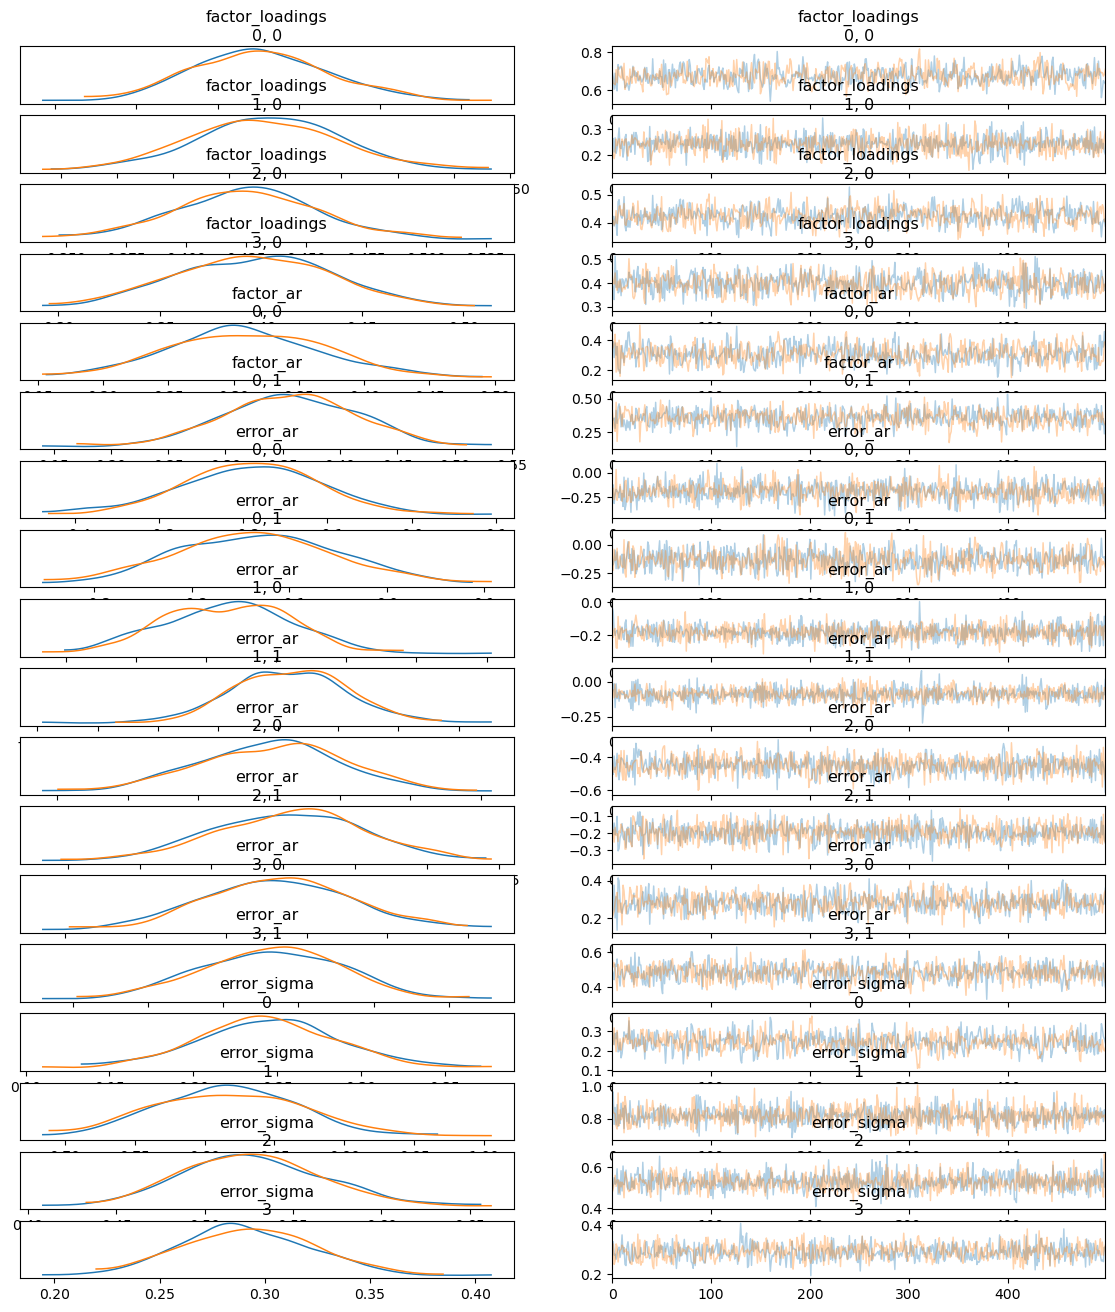

In [ ]:
az.plot_trace(idata_dfm_py, var_names=var_names_list_dfm_py, figsize=(14, 16), compact=False);

We compare the **posterior distributions** of the model parameters with the reference values estimated by Statsmodels.  
All reference estimates **fall within the Bayesian credible intervals**, indicating good agreement between the two approaches.


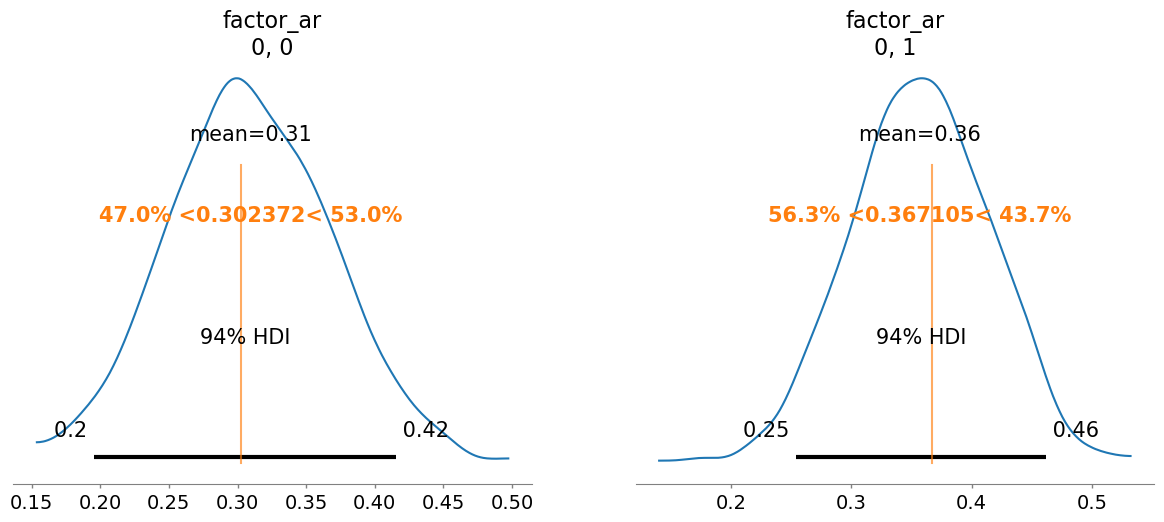

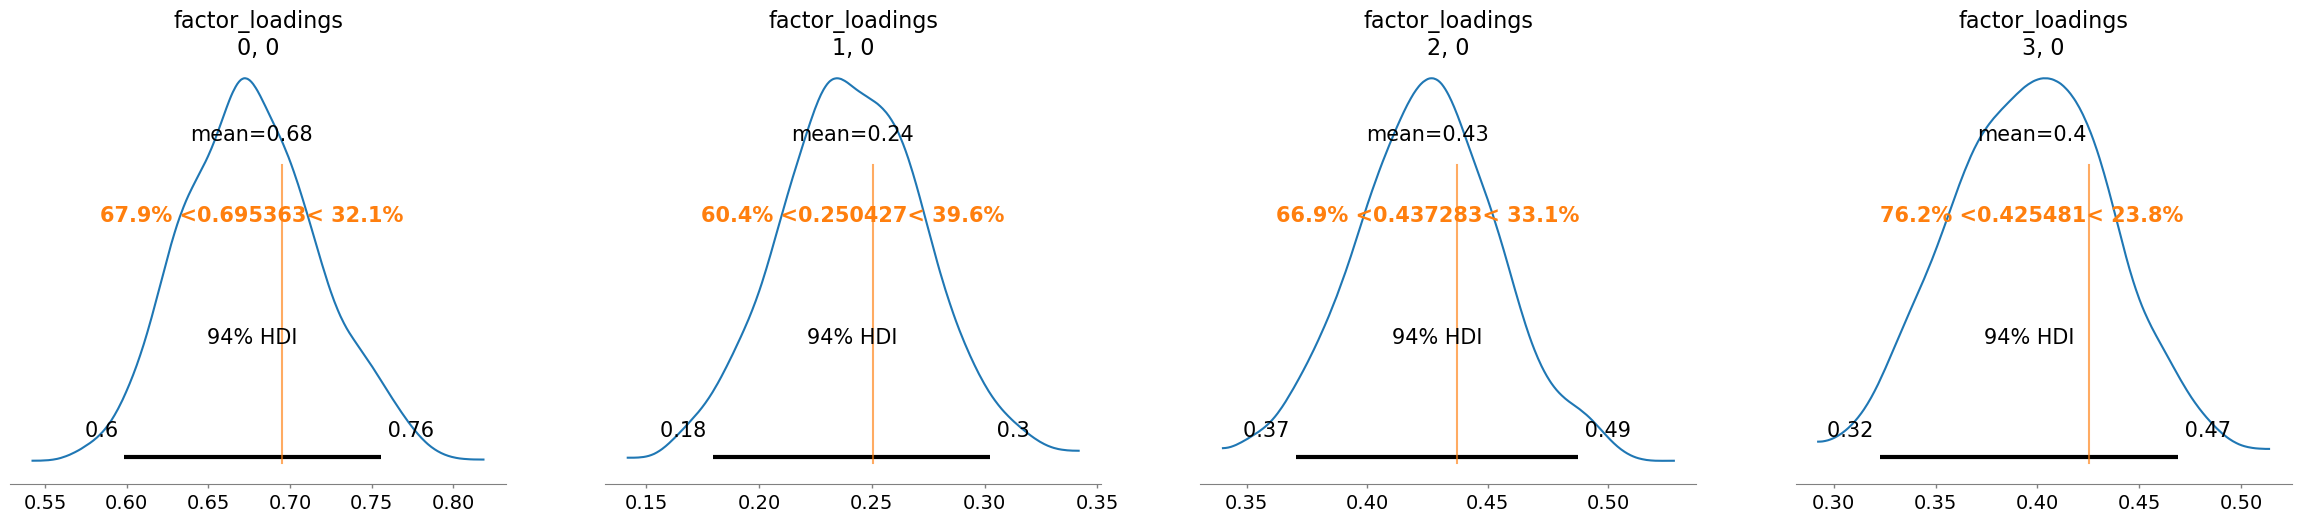

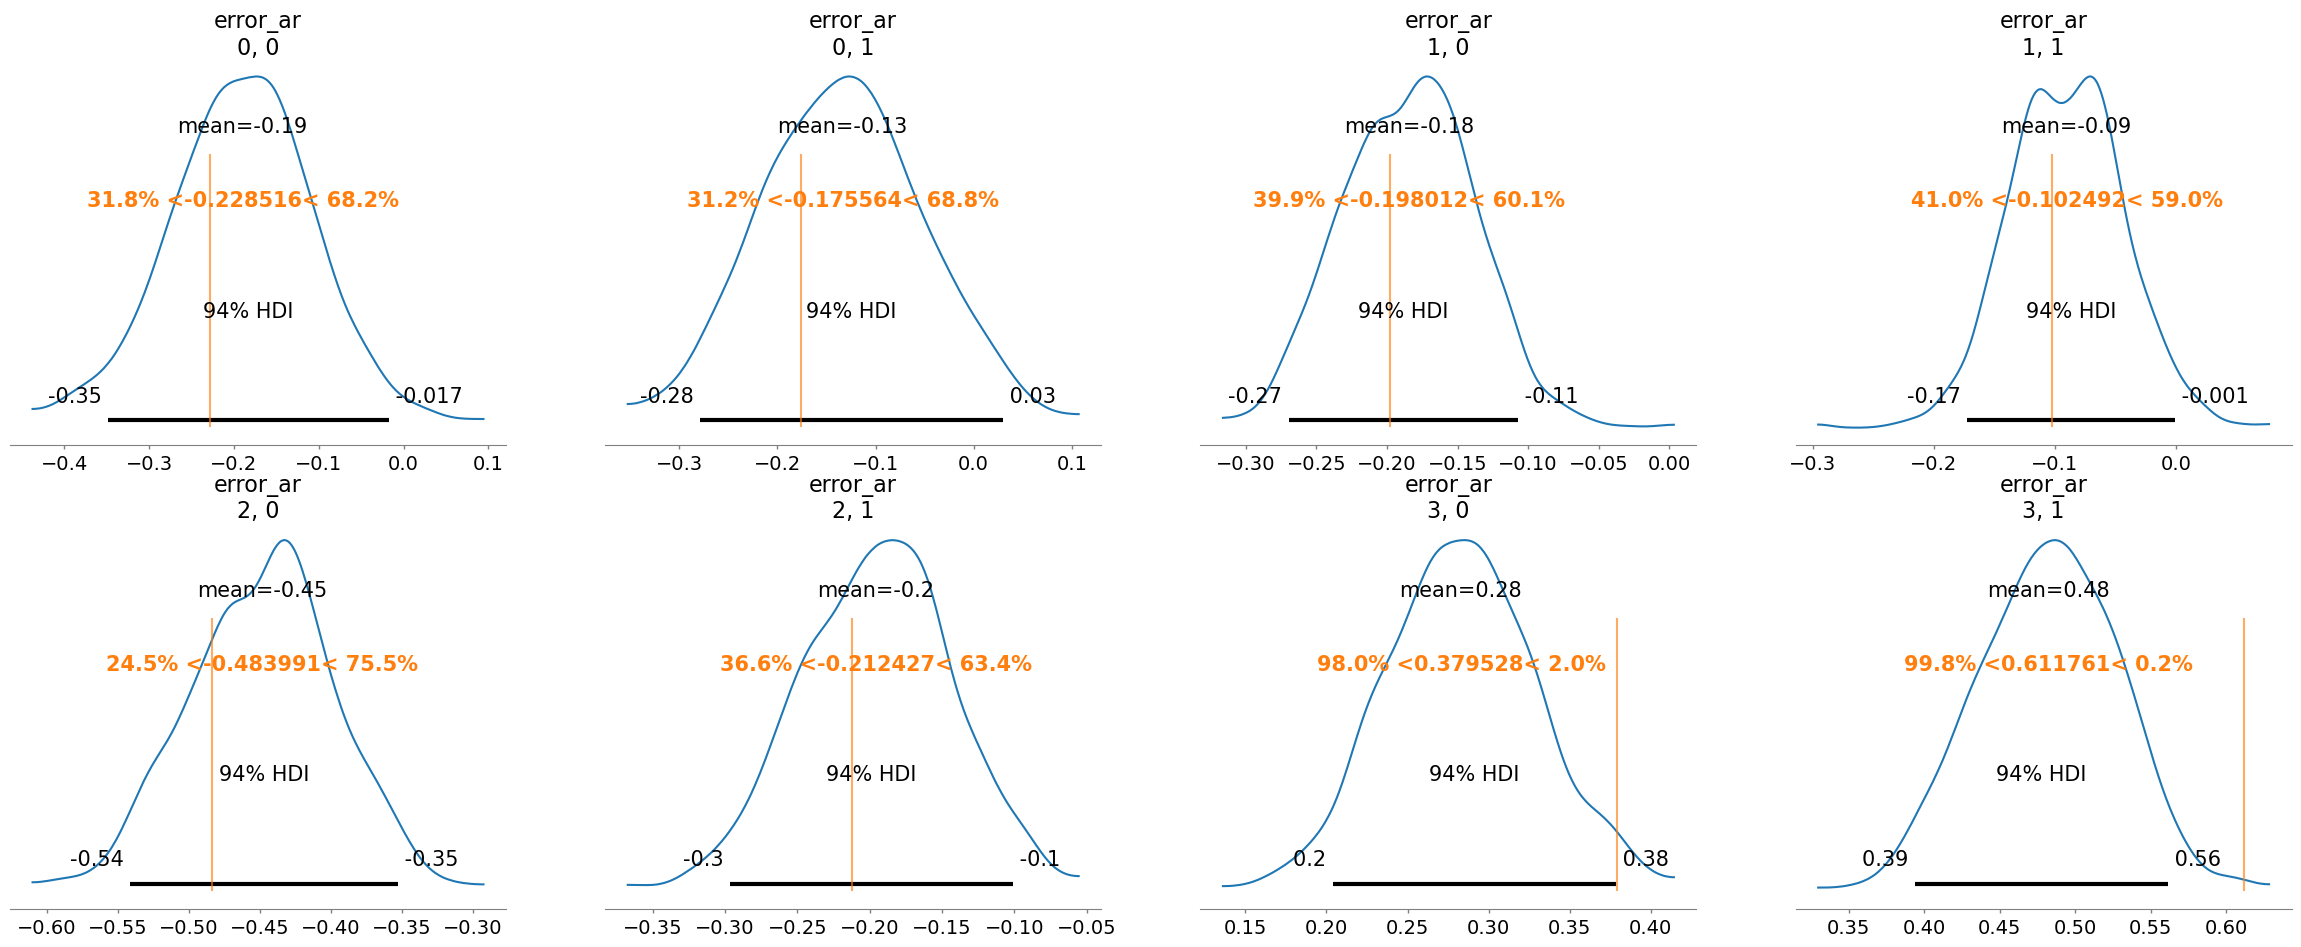

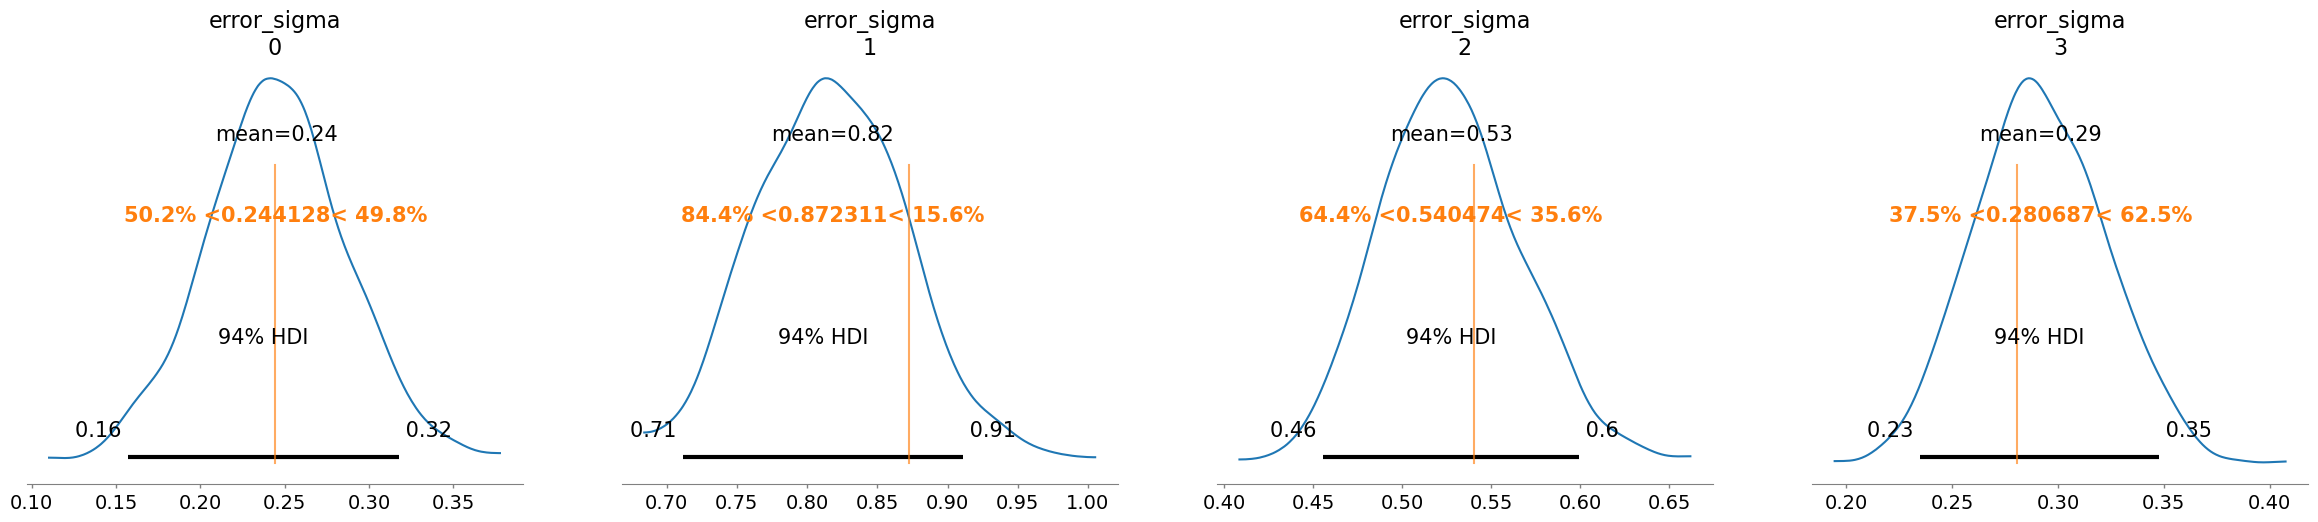

In [83]:
params = res.params.to_dict()

# Define ref values in an organized way
ref_vals = {
    "factor_ar": [params["L1.f1.f1"], params["L2.f1.f1"]],
    "factor_loadings": [
        -params["loading.f1.std_indprod"],
        -params["loading.f1.std_income"],
        -params["loading.f1.std_sales"],
        -params["loading.f1.std_emp"],
    ],
    "error_ar": [
        params["L1.e(std_indprod).e(std_indprod)"],
        params["L2.e(std_indprod).e(std_indprod)"],
        params["L1.e(std_income).e(std_income)"],
        params["L2.e(std_income).e(std_income)"],
        params["L1.e(std_sales).e(std_sales)"],
        params["L2.e(std_sales).e(std_sales)"],
        params["L1.e(std_emp).e(std_emp)"],
        params["L2.e(std_emp).e(std_emp)"],
    ],
    "error_sigma": [
        params["sigma2.std_indprod"],
        params["sigma2.std_income"],
        params["sigma2.std_sales"],
        params["sigma2.std_emp"],
    ],
}


# Helper function to plot
def plot_param_posteriors(var_name, ref_val_list):
    az.plot_posterior(idata_dfm_py, var_names=[var_name], ref_val=ref_val_list)


# Plot all
for var, ref in ref_vals.items():
    plot_param_posteriors(var, ref)

In the following cells, we compute the **coincident index** in the Bayesian framework, allowing us to compare our results against the **reference USPHCI index**.  

We construct the index **symbolically** and sample its **posterior distribution**, demonstrating how Bayesian modeling provides a full distribution for derived quantities that depend on other random variables.

Key steps include:  
- **Building the state-space graph** of the `BayesianDynamicFactor` model and retrieving state space matrices.  
- **Inserting random variables** for the model parameters.  
- Passing the observed data through the **Kalman filter**, which provides **predicted covariances** and **filtered states**.  
- Computing the **Kalman gain** in a symbolic way to obtain the **factor mean vector**.  
- Scaling and normalizing the factor to match the USPHCI base year.  
- Constructing the **coincident index** as the cumulative sum of the scaled increments.  
- Sampling the **posterior predictive distribution** of both the factor and the coincident index to quantify uncertainty.  

This approach illustrates the Bayesian advantage: not only do we estimate latent factors, but we also obtain a **distribution over any quantity derived from them**, such as the coincident index, with full uncertainty propagation.


In [ ]:
with pm.Model() as index_mod:
    dfm._build_dummy_graph()
    dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = dfm.unpack_statespace()

    dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariances"]
    filtered_state = index_mod["filtered_states"]

    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6

        K = pt.linalg.solve(F, PZT.T, assume_a="pos", check_finite=False).T
        return K

    ss_kalman_gain, updates = pytensor.scan(
        step, non_sequences=[Z, T, H], sequences=[predicted_covariance]
    )

    ss_kalman_gain = ss_kalman_gain[-1]  # Get the last Kalman gain (steady state)

    k_states = T.shape[0]
    W1 = pt.linalg.inv(
        pt.eye(k_states) - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, Z), T)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())

    state_0 = filtered_state[..., 0]

    # Normalization
    normalizer = np.std(usphci.diff()[1:]) / pt.std(state_0)
    state_0_scaled = state_0 * normalizer

    # Initial value (scalar)
    initial_value = usphci.iloc[0] * factor_mean / dusphci.mean()

    # Increments: each increment is state[t] + factor_mean (broadcasted)
    increments = state_0_scaled + factor_mean  # shape: (T,)

    # Cumulative sum of increments
    cumsum_increments = pt.cumsum(increments)
    coincident_index = pt.concatenate([[initial_value], initial_value + cumsum_increments])

    # Normalize to match USPHCI base year (e.g., July 1992)
    ref_idx = list(data.index).index(pd.Timestamp("1992-07-01"))
    base_value = usphci.loc["1992-07-01"]
    normalization_factor = base_value / coincident_index[ref_idx]
    coincident_index = coincident_index * normalization_factor

    pm.Deterministic("factor_mean", factor_mean)

    factor_mean_idata_dfm_py = pm.sample_posterior_predictive(
        idata_dfm_py, var_names=["factor_mean"]
    )
    filtered_state_idata_dfm_py = pm.sample_posterior_predictive(
        idata_dfm_py, var_names=["filtered_states"]
    )

    pm.Deterministic("coincident_index", coincident_index)
    coincident_index_idata_dfm_py = pm.sample_posterior_predictive(
        idata_dfm_py, var_names=["coincident_index"]
    )

Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

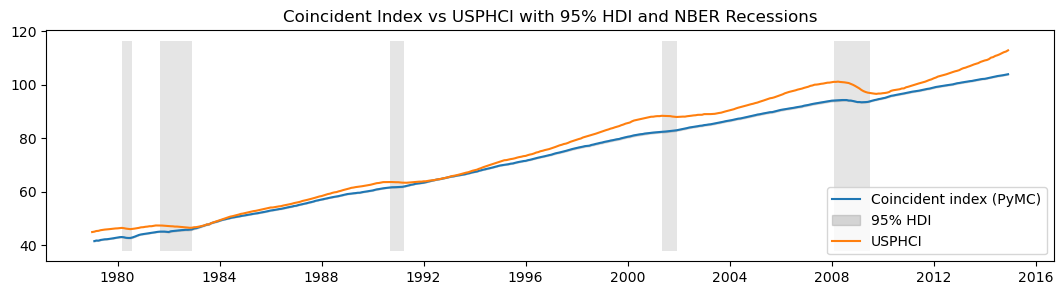

In [91]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index_pymc_samples_dfm_py = coincident_index_idata_dfm_py.posterior_predictive[
    "coincident_index"
].values
coincident_index_pymc_dfm_py = coincident_index_pymc_samples_dfm_py.mean(axis=(0, 1))


hdi_index_dfm_py = az.hdi(coincident_index_pymc_samples_dfm_py, hdi_prob=0.95)
lower_index_dfm_py, upper_index_dfm_py = hdi_index_dfm_py[..., 0], hdi_index_dfm_py[..., 1]

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index_pymc_dfm_py[1:], label="Coincident index (PyMC)")
ax.fill_between(
    dates, lower_index_dfm_py[1:], upper_index_dfm_py[1:], color="gray", alpha=0.3, label="95% HDI"
)
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")

# Add title
ax.set_title("Coincident Index vs USPHCI with 95% HDI and NBER Recessions")

# Add legend
ax.legend(loc="lower right")

# Retrieve and plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1)

In [92]:
# Extract posterior predictive samples
state_samples_dfm_py = filtered_state_idata_dfm_py.posterior_predictive["filtered_states"].values

# Select the first state (index 0)
state_0_samples_dfm_py = state_samples_dfm_py[:, :, :, 0]

# Average over chains and draws to get posterior mean for each time point
state_0_mean_dfm_py = state_0_samples_dfm_py.mean(axis=(0, 1))

# Get the time index from your observed data for x-axis
dates = filtered_state_idata_dfm_py.observed_data.time.values

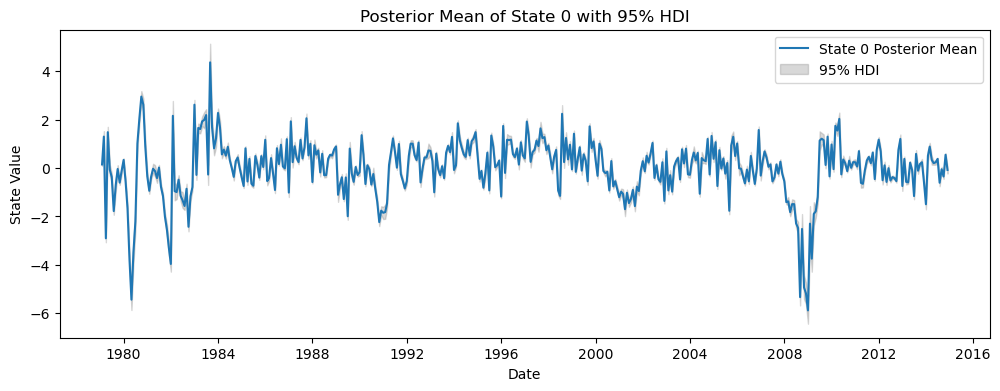

In [93]:
hdi_state_dfm_py = az.hdi(state_0_samples_dfm_py, hdi_prob=0.95)
lower_state_dfm_py, upper_state_dfm_py = hdi_state_dfm_py[..., 0], hdi_state_dfm_py[..., 1]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, state_0_mean_dfm_py, label="State 0 Posterior Mean")
ax.fill_between(
    dates, lower_state_dfm_py, upper_state_dfm_py, color="gray", alpha=0.3, label="95% HDI"
)
ax.set_xlabel("Date")
ax.set_ylabel("State Value")
ax.set_title("Posterior Mean of State 0 with 95% HDI")
ax.legend()
plt.show()

## Comparison of results obtained via PyMC and Stats

We are **satisfied with the results**: the Bayesian estimates closely match the classical Statsmodels outcomes.  

- The **latent factor** from PyMC aligns well with the Statsmodels factor, and the 95% credible interval captures the expected uncertainty.  
- The **coincident index** derived from the Bayesian model also shows strong agreement with both the Statsmodels index and the USPHCI reference, demonstrating that the Bayesian approach successfully reproduces the main features of the business cycle.


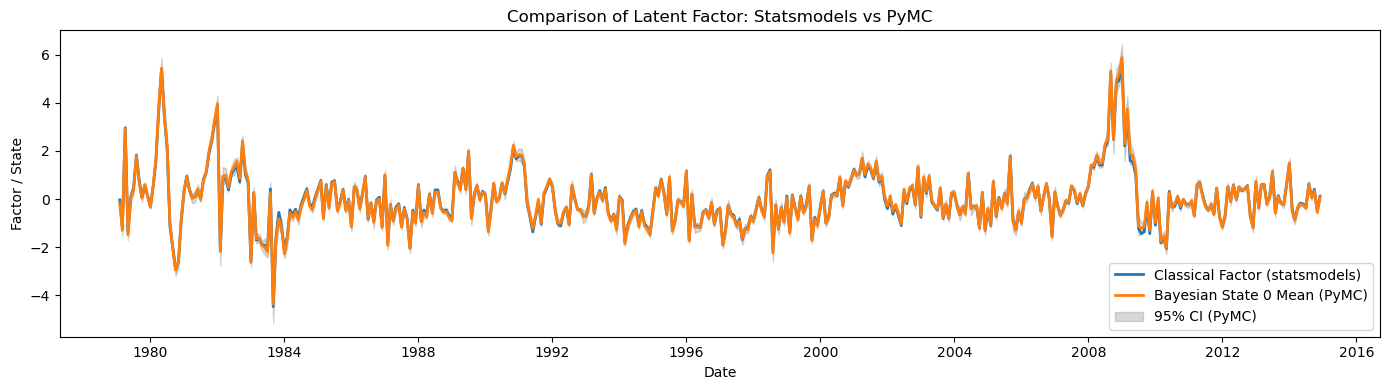

In [89]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(dates, res.factors.filtered[0], label="Classical Factor (statsmodels)", linewidth=2)
ax.plot(dates, -state_0_mean_dfm_py, label="Bayesian State 0 Mean (PyMC)", linewidth=2)
ax.fill_between(
    dates, -lower_state_dfm_py, -upper_state_dfm_py, color="gray", alpha=0.3, label="95% CI (PyMC)"
)
ax.legend()
ax.set_title("Comparison of Latent Factor: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Factor / State")
plt.tight_layout()
plt.show()

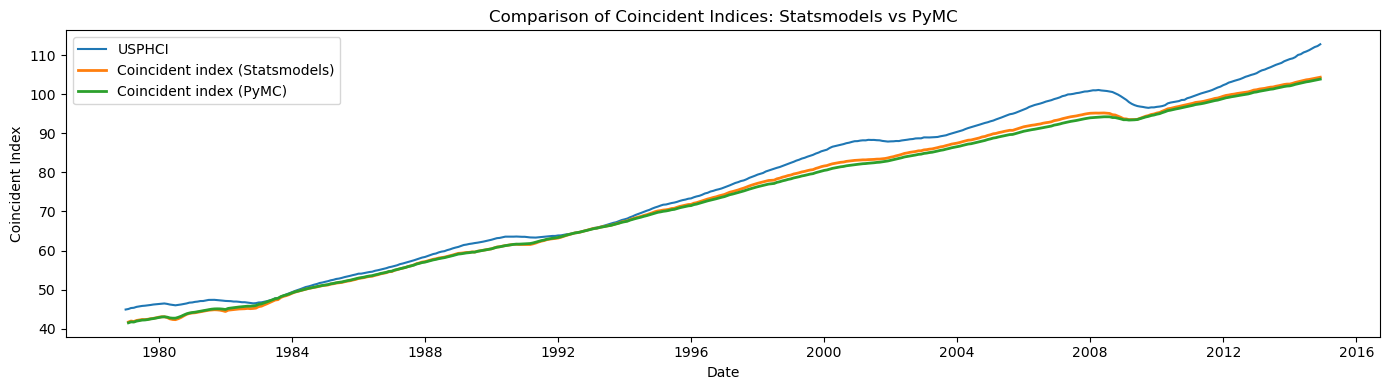

In [90]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.plot(dates, coincident_index_res, label="Coincident index (Statsmodels)", linewidth=2)
ax.plot(dates, coincident_index_pymc_dfm_py[1:], label="Coincident index (PyMC)", linewidth=2)
ax.legend()
ax.set_title("Comparison of Coincident Indices: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Coincident Index")
plt.tight_layout()
plt.show()